### Installing required libraries

In [ ]:
!pip install remotezip tqdm opencv-python einops
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.2 MB/s eta 0:00:00


In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


### Importing Libraries

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz
import einops

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

### Importing the UCF101 dataset

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

### Data Exploration

In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g03_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g03_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g03_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g03_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g03_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g03_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g04_c07.avi',
 'UCF101/v_ApplyEyeMakeup_g05_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g05_c02.avi',


In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [ ]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [ ]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


In [ ]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

#### Video classes in the dataset

In [ ]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UCF101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

#### Splitting the dataset into train, validation and test sets

In [ ]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir  = download_dir)

train :


100%|██████████| 300/300 [01:29<00:00,  3.36it/s]


val :


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


test :


100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


In [ ]:
subset_paths

{'train': PosixPath('UCF101_subset/train'),
 'val': PosixPath('UCF101_subset/val'),
 'test': PosixPath('UCF101_subset/test')}

In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


#### Functions for extracting and formatting the frames from a video

In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result


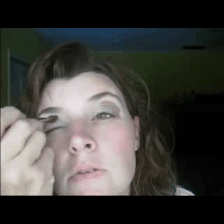

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')

# docs-infra: no-execute
#/content/UCF101_subset/test/ApplyEyeMakeup/v_ApplyEyeMakeup_g24_c06.avi
# ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
ucf_sample_video = frames_from_video_file(subset_paths['test'] / 'ApplyEyeMakeup' / ('v_' + 'ApplyEyeMakeup' + '_g06_c07.avi'), 50)

to_gif(ucf_sample_video)

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames)
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 8


In [ ]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

### Model Construction

#### 1. (2 + 1) D Convolution

In [ ]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding, name=""):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension.
    """
    super().__init__(name=name)
    self.seq = keras.Sequential([
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def call(self, x):
    return self.seq(x)

#### 2. Main Resiudal block with convolution, layer normalisation and ReLU activation function

In [ ]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size, name):
    super().__init__(name=name)
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same', name=name+"1"),
        layers.LayerNormalization(name=name+"2"),
        layers.ReLU(name=name+"3"),
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same', name=name+"4"),
        layers.LayerNormalization(name=name+'5')
    ])

  def call(self, x):
    return self.seq(x)

In [ ]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different
    sized filters and downsampled.
  """
  def __init__(self, units, name):
    super().__init__(name=name)
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

def add_residual_block(input, filters, kernel_size, name1, name2, name3=""):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters,
                     kernel_size, name=name1)(input)

  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1], name=name3)(res)

  return layers.add([res, out], name=name2)

#### 3. Video Resizing Layer

In [ ]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width, name):
    super().__init__(name=name)
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.

      Args:
        video: Tensor representation of the video, in the form of a set of frames.

      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height,
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

#### Model for classification of videos

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [ ]:
frames, label = next(iter(train_ds))
model.build(frames)

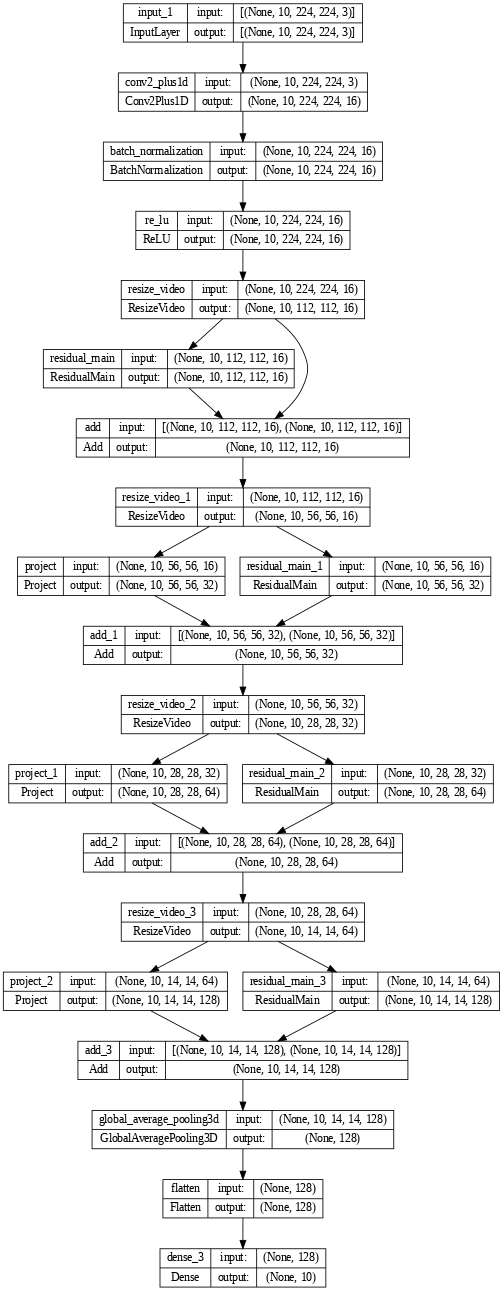

In [ ]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

#### Training the model

In [ ]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])
history = model.fit(x = train_ds,
                    epochs = 50,
                    validation_data = val_ds)

Epoch 1/50
38/38 [==============================] - 88s 2s/step - loss: 2.4615 - accuracy: 0.1567 - val_loss: 2.6708 - val_accuracy: 0.1300
Epoch 2/50
38/38 [==============================] - 60s 2s/step - loss: 2.1241 - accuracy: 0.2433 - val_loss: 2.2801 - val_accuracy: 0.1900
Epoch 3/50
38/38 [==============================] - 59s 2s/step - loss: 2.0925 - accuracy: 0.2367 - val_loss: 2.7820 - val_accuracy: 0.1500
Epoch 4/50
38/38 [==============================] - 60s 2s/step - loss: 1.9666 - accuracy: 0.2733 - val_loss: 2.7013 - val_accuracy: 0.1700
Epoch 5/50
38/38 [==============================] - 60s 2s/step - loss: 1.8909 - accuracy: 0.3333 - val_loss: 2.4781 - val_accuracy: 0.2000
Epoch 6/50
38/38 [==============================] - 68s 2s/step - loss: 1.8120 - accuracy: 0.2967 - val_loss: 1.8708 - val_accuracy: 0.3400
Epoch 7/50
38/38 [==============================] - 65s 2s/step - loss: 1.7605 - accuracy: 0.3500 - val_loss: 2.1684 - val_accuracy: 0.1800
Epoch 8/50
38/38 [==

#### Saving the weights (used later for embedding-extractor model)

In [ ]:
model.save_weights('classfn_weights.h5')
(model.to_json())

{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 10, 224, 224, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "registered_name": null, "name": "input_1", "inbound_nodes": []}, {"module": null, "class_name": "Conv2Plus1D", "config": {"filters": 16, "kernel_size": [3, 7, 7], "padding": "same"}, "registered_name": "Conv2Plus1D", "build_config": {"input_shape": [null, 10, 224, 224, 3]}, "name": "conv2_plus1d", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"module": "keras.layers", "class_name": "BatchNormalization", "config": {"name": "batch_normalization", "trainable": true, "dtype": "float32", "axis": [4], "momentum": 0.99, "epsilon": 0.001, "center": true, "scale": true, "beta_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "gamma_initializer": {"module": "keras.ini

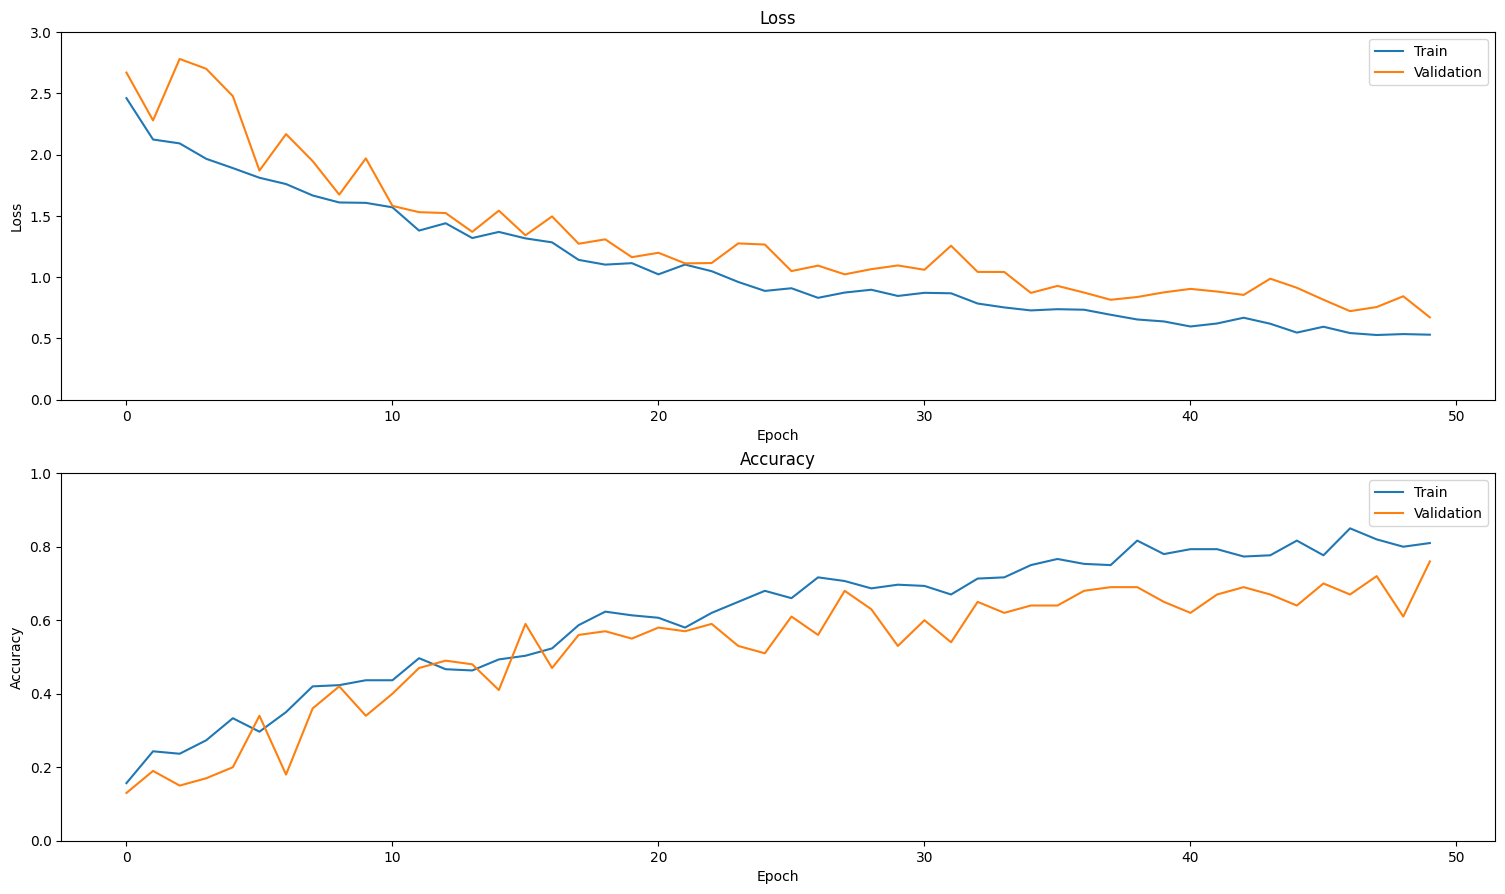

In [ ]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')

  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'])

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [ ]:
model.evaluate(test_ds, return_dict=True)

13/13 [==============================] - 12s 961ms/step - loss: 0.9262 - accuracy: 0.7300


{'loss': 0.9261876940727234, 'accuracy': 0.7300000190734863}

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

38/38 [==============================] - 37s 942ms/step


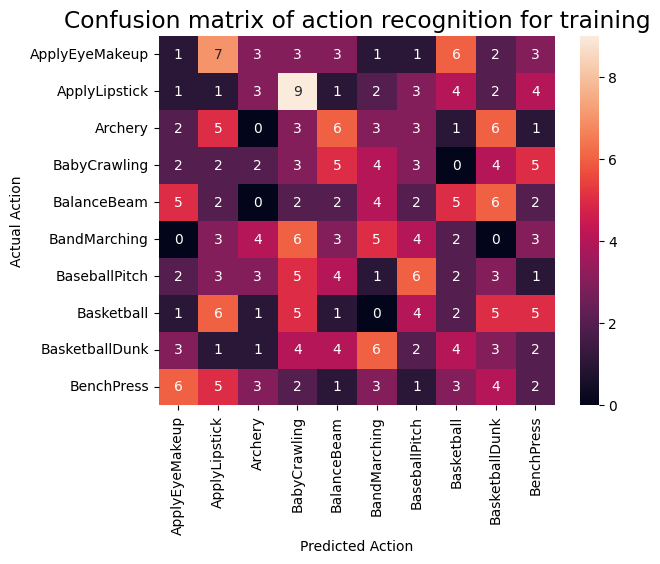

In [ ]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

13/13 [==============================] - 12s 953ms/step


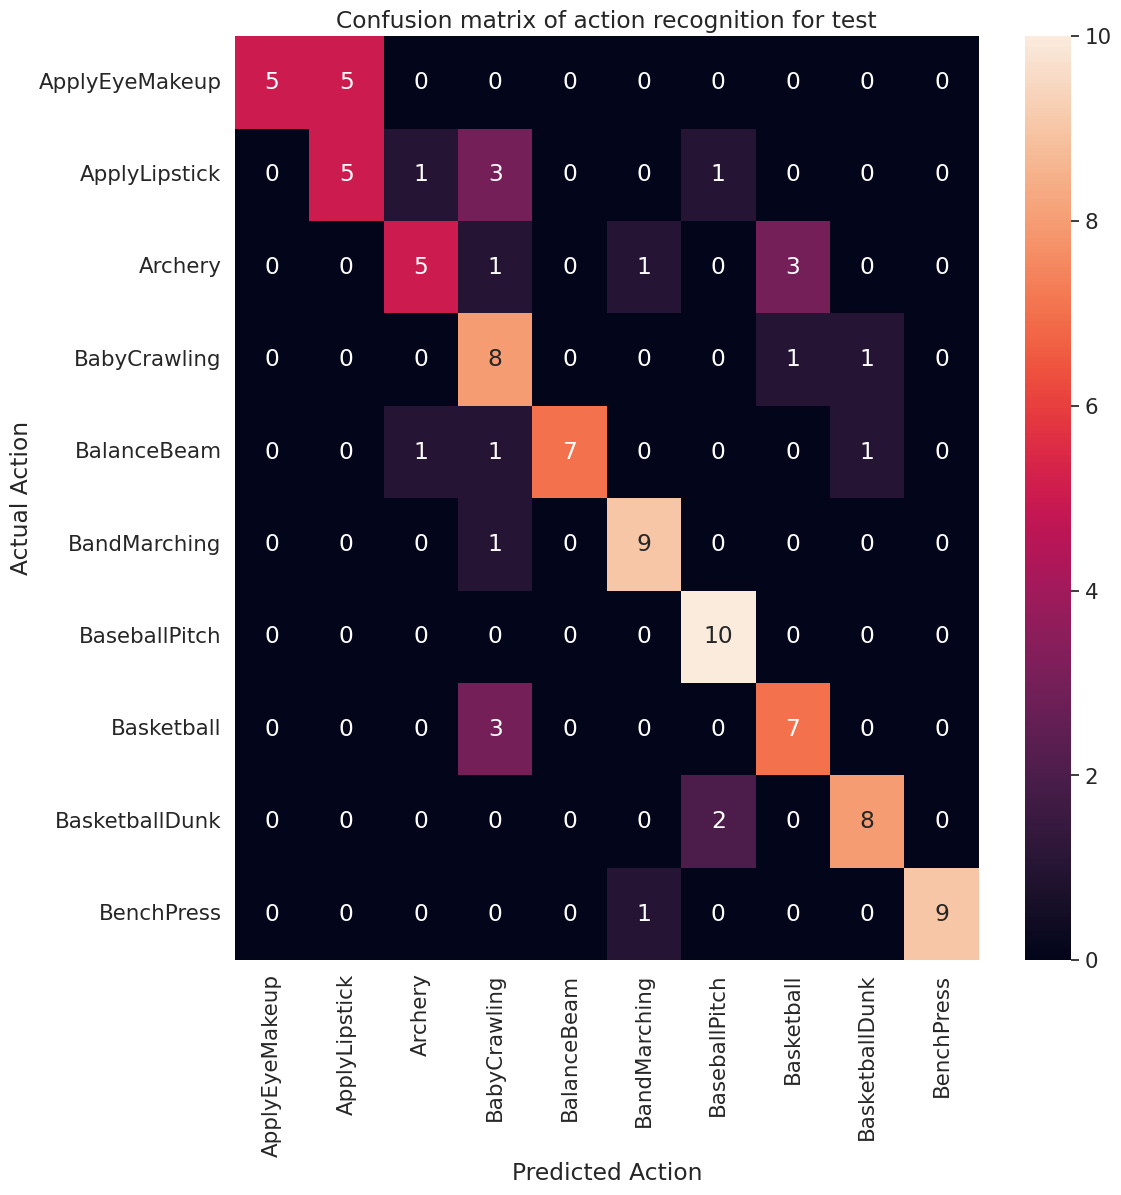

In [ ]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values.

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative

    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative

    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision

    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall

  return precision, recall

In [ ]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [ ]:
precision

{'ApplyEyeMakeup': 1.0,
 'ApplyLipstick': 0.5,
 'Archery': 0.7142857142857143,
 'BabyCrawling': 0.47058823529411764,
 'BalanceBeam': 1.0,
 'BandMarching': 0.8181818181818182,
 'BaseballPitch': 0.7692307692307693,
 'Basketball': 0.6363636363636364,
 'BasketballDunk': 0.8,
 'BenchPress': 1.0}

In [ ]:
recall

{'ApplyEyeMakeup': 0.5,
 'ApplyLipstick': 0.5,
 'Archery': 0.5,
 'BabyCrawling': 0.8,
 'BalanceBeam': 0.7,
 'BandMarching': 0.9,
 'BaseballPitch': 1.0,
 'Basketball': 0.7,
 'BasketballDunk': 0.8,
 'BenchPress': 0.9}

### Model for extracting Video Embeddings

In [ ]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]), name="input_1")
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same', name='conv2_plus1d')(x)
x = layers.BatchNormalization(name="batch_normalisation")(x)
x = layers.ReLU(name="re_lu")(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2, name="resize_video")(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3), name1="residual_main", name2="add")
x = ResizeVideo(HEIGHT // 4, WIDTH // 4, name="resize_video_1")(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3), name1="residual_main_1", name2="add_1", name3="project")
x = ResizeVideo(HEIGHT // 8, WIDTH // 8, name="resize_video_2")(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3), name1="residual_main_2", name2="add_2", name3="project_1")
x = ResizeVideo(HEIGHT // 16, WIDTH // 16, name="resize_video_3")(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3), name1="residual_main_3", name2="add_3", name3="project_2")

x = layers.GlobalAveragePooling3D(name="global_average_pooling_3d")(x)
x = layers.Flatten(name="flatten")(x)

model2 = keras.Model(input, x)

In [ ]:
frames2, label2 = next(iter(train_ds))
model2.build(frames2)

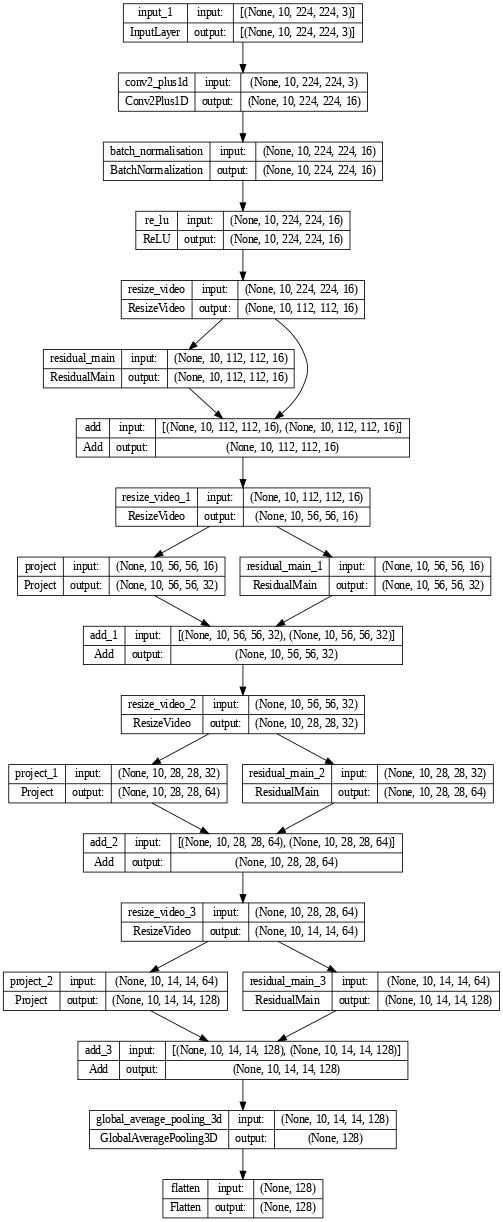

In [ ]:
# Visualize the model
keras.utils.plot_model(model2, expand_nested=True, dpi=60, show_shapes=True)

#### Loading the weights from the previous model

In [ ]:
model2.load_weights('classfn_weights.h5', by_name=True)

#### Sample Video Embedding

In [ ]:
res = model2.predict(test_ds)
res[0]

13/13 [==============================] - 120s 9s/step


array([ 0.33571884,  0.5892292 ,  1.167744  , -0.5396427 ,  1.0045893 ,
       -2.2425408 , -0.61576825, -0.17465328,  0.06837346, -0.6762465 ,
        0.72588784,  0.9723954 , -0.7795914 , -1.98412   ,  0.6931053 ,
        0.02739622,  0.8029847 ,  2.2446127 ,  1.094262  , -1.0831331 ,
       -0.31094566, -0.37202892,  1.2274538 , -0.36289603,  0.7020377 ,
       -2.124189  , -0.6593339 ,  1.3895692 , -0.19806945,  1.5872223 ,
        0.64429486, -1.2345074 ,  0.74359334,  0.17333895,  0.0123109 ,
        1.2950096 , -0.6176653 , -1.3100346 ,  0.48648185, -0.23764369,
        0.10001542, -2.864291  ,  1.5047828 , -1.7750285 , -0.23660213,
       -0.12059441, -0.7529927 , -1.0473405 ,  2.006071  , -1.3557802 ,
       -0.80625814, -1.9309942 ,  1.2694817 ,  1.8522274 , -0.3916614 ,
        1.0241208 ,  0.61946064, -0.82796806,  1.0785908 , -1.6073202 ,
        2.026812  ,  1.4562862 ,  1.3114215 , -0.07326875,  1.7200009 ,
       -0.9566392 , -2.2189672 ,  1.3789064 , -0.6483964 ,  1.25

In [ ]:
x = [labels for _, labels in test_ds.unbatch()]

In [ ]:
labels = list(fg.class_ids_for_name.keys())
labels

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress']

In [ ]:
for i in range(len(x)):
  print(i, labels[int(x[i])])

0 Basketball
1 Basketball
2 Basketball
3 Basketball
4 Basketball
5 Basketball
6 Basketball
7 Basketball
8 Basketball
9 Basketball
10 BaseballPitch
11 BaseballPitch
12 BaseballPitch
13 BaseballPitch
14 BaseballPitch
15 BaseballPitch
16 BaseballPitch
17 BaseballPitch
18 BaseballPitch
19 BaseballPitch
20 BasketballDunk
21 BasketballDunk
22 BasketballDunk
23 BasketballDunk
24 BasketballDunk
25 BasketballDunk
26 BasketballDunk
27 BasketballDunk
28 BasketballDunk
29 BasketballDunk
30 ApplyEyeMakeup
31 ApplyEyeMakeup
32 ApplyEyeMakeup
33 ApplyEyeMakeup
34 ApplyEyeMakeup
35 ApplyEyeMakeup
36 ApplyEyeMakeup
37 ApplyEyeMakeup
38 ApplyEyeMakeup
39 ApplyEyeMakeup
40 BandMarching
41 BandMarching
42 BandMarching
43 BandMarching
44 BandMarching
45 BandMarching
46 BandMarching
47 BandMarching
48 BandMarching
49 BandMarching
50 BabyCrawling
51 BabyCrawling
52 BabyCrawling
53 BabyCrawling
54 BabyCrawling
55 BabyCrawling
56 BabyCrawling
57 BabyCrawling
58 BabyCrawling
59 BabyCrawling
60 ApplyLipstick
61 

#### Cosine Similarities for videos in the test set

In [ ]:
from numpy import dot
from numpy.linalg import norm

sim_scores = []
target = 60
print(labels[x[target]])
for i in range(0, len(res)):
  if i != target:
    sim_scores.append(dot(res[target], res[i])/(norm(res[target]) * norm(res[i])))
    print(i, labels[x[i]], sim_scores[-1])

ApplyLipstick
0 Basketball 0.88950235
1 Basketball 0.9233697
2 Basketball 0.9298867
3 Basketball 0.94171506
4 Basketball 0.9177141
5 Basketball 0.85757923
6 Basketball 0.90750897
7 Basketball 0.9391952
8 Basketball 0.9233858
9 Basketball 0.8687773
10 BaseballPitch 0.93305963
11 BaseballPitch 0.953527
12 BaseballPitch 0.93430614
13 BaseballPitch 0.87143713
14 BaseballPitch 0.9377989
15 BaseballPitch 0.92825824
16 BaseballPitch 0.9329575
17 BaseballPitch 0.9459681
18 BaseballPitch 0.92320067
19 BaseballPitch 0.9285368
20 BasketballDunk 0.8978655
21 BasketballDunk 0.8615642
22 BasketballDunk 0.9093152
23 BasketballDunk 0.8933451
24 BasketballDunk 0.8815121
25 BasketballDunk 0.86126834
26 BasketballDunk 0.90894663
27 BasketballDunk 0.89069563
28 BasketballDunk 0.8916679
29 BasketballDunk 0.8816179
30 ApplyEyeMakeup 0.93110734
31 ApplyEyeMakeup 0.9443194
32 ApplyEyeMakeup 0.9590944
33 ApplyEyeMakeup 0.9535597
34 ApplyEyeMakeup 0.95004225
35 ApplyEyeMakeup 0.9886907
36 ApplyEyeMakeup 0.98967


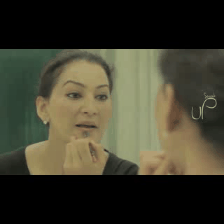

In [ ]:
ucf_sample_video = frames_from_video_file(subset_paths['test'] / labels[x[target]] / ('v_' + labels[x[target]] + '_g02_c03.avi'), 50)

to_gif(ucf_sample_video)


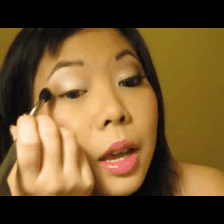

In [ ]:
ucf_sample_video = frames_from_video_file(subset_paths['test'] / labels[x[30]] / ('v_' + labels[x[30]] + '_g03_c03.avi'), 50)
to_gif(ucf_sample_video)

#### Recommended videos

In [ ]:
def argsort(seq):
    return [x for x,y in sorted(enumerate(seq), key = lambda x: x[1], reverse=True)]

[67, 63, 66, 60, 36, 35, 39, 61]

In [ ]:
for i in argsort(sim_scores)[:8]:
  print(i, labels[x[i]], res[i])

67 ApplyLipstick
63 ApplyLipstick
66 ApplyLipstick
60 ApplyLipstick
36 ApplyEyeMakeup
35 ApplyEyeMakeup
39 ApplyEyeMakeup
61 ApplyLipstick


### Task: To use k-NN algorithm for ranking the videos
![image.png](https://iq.opengenus.org/content/images/2018/12/distance.jpg)

Using Manhattan Distance

In [ ]:
sim_scores2 = []
target = 60
print(labels[x[target]])
for i in range(0, len(res)):
  if i != target:
    sim_scores2.append(np.sum(abs(res[target] - res[i])))
    print(i, labels[x[i]], sim_scores2[-1])

ApplyLipstick
0 Basketball 58.303314
1 Basketball 51.347412
2 Basketball 48.016747
3 Basketball 43.849625
4 Basketball 59.662056
5 Basketball 69.132355
6 Basketball 57.18241
7 Basketball 43.114166
8 Basketball 48.607094
9 Basketball 66.820045
10 BaseballPitch 51.979683
11 BaseballPitch 39.521515
12 BaseballPitch 47.901993
13 BaseballPitch 66.23773
14 BaseballPitch 46.10277
15 BaseballPitch 50.53222
16 BaseballPitch 46.392384
17 BaseballPitch 46.071472
18 BaseballPitch 50.502354
19 BaseballPitch 51.060265
20 BasketballDunk 60.524834
21 BasketballDunk 71.5437
22 BasketballDunk 56.965263
23 BasketballDunk 59.944744
24 BasketballDunk 63.191
25 BasketballDunk 68.50299
26 BasketballDunk 57.125656
27 BasketballDunk 58.790127
28 BasketballDunk 59.41761
29 BasketballDunk 65.960594
30 ApplyEyeMakeup 49.230217
31 ApplyEyeMakeup 41.801308
32 ApplyEyeMakeup 42.524143
33 ApplyEyeMakeup 43.885506
34 ApplyEyeMakeup 46.593834
35 ApplyEyeMakeup 18.883884
36 ApplyEyeMakeup 19.77922
37 ApplyEyeMakeup 40.2

In [ ]:
def argsort_asc(seq):
    return [x for x,y in sorted(enumerate(seq), key = lambda x: x[1])]
for i in argsort_asc(sim_scores2)[:8]:
  print(i, labels[x[i]])

67 ApplyLipstick
63 ApplyLipstick
60 ApplyLipstick
66 ApplyLipstick
35 ApplyEyeMakeup
36 ApplyEyeMakeup
39 ApplyEyeMakeup
56 BabyCrawling


Using Euclidean Distance

In [ ]:
sim_scores3 = []
target = 60
print(labels[x[target]])
for i in range(0, len(res)):
  if i != target:
    sim_scores3.append(np.sum((res[i] - res[target]) ** 2) ** 0.5)
    print(i, labels[x[i]], sim_scores3[-1])

ApplyLipstick
0 Basketball 6.457897278205916
1 Basketball 5.619876138537219
2 Basketball 5.327649942737747
3 Basketball 4.839677833995279
4 Basketball 6.834212952111215
5 Basketball 7.2646467965492505
6 Basketball 6.067061448439485
7 Basketball 4.873865240025588
8 Basketball 5.413103114965755
9 Basketball 7.11941952257197
10 BaseballPitch 5.707648168872089
11 BaseballPitch 4.396201939367574
12 BaseballPitch 5.526429052793632
13 BaseballPitch 7.3660902094085525
14 BaseballPitch 5.200870059657461
15 BaseballPitch 5.6091260934504374
16 BaseballPitch 5.236458890221939
17 BaseballPitch 5.095353886197301
18 BaseballPitch 5.517459207789319
19 BaseballPitch 5.880041029391225
20 BasketballDunk 6.674111913687526
21 BasketballDunk 8.004225092020492
22 BasketballDunk 6.397117991041637
23 BasketballDunk 6.662016900102108
24 BasketballDunk 7.054681011209641
25 BasketballDunk 7.649708222453447
26 BasketballDunk 6.409959268187608
27 BasketballDunk 6.4999744708220115
28 BasketballDunk 6.648159787824983

In [ ]:
for i in argsort_asc(sim_scores3)[:8]:
  print(i, labels[x[i]])

67 ApplyLipstick
63 ApplyLipstick
60 ApplyLipstick
66 ApplyLipstick
35 ApplyEyeMakeup
36 ApplyEyeMakeup
39 ApplyEyeMakeup
56 BabyCrawling


Using Chebyshev distance

In [ ]:
sim_scores4 = []
target = 60
print(labels[x[target]])
for i in range(0, len(res)):
  if i != target:
    sim_scores4.append(max((res[i] - res[target])))
    print(i, labels[x[i]], sim_scores4[-1])

ApplyLipstick
0 Basketball 1.3480486
1 Basketball 1.1954135
2 Basketball 1.2890283
3 Basketball 1.0377007
4 Basketball 2.0737882
5 Basketball 1.8497698
6 Basketball 1.1966015
7 Basketball 1.3659222
8 Basketball 1.3124697
9 Basketball 1.9497399
10 BaseballPitch 1.3019184
11 BaseballPitch 0.85492265
12 BaseballPitch 1.6303287
13 BaseballPitch 1.6763047
14 BaseballPitch 1.4056652
15 BaseballPitch 1.4624768
16 BaseballPitch 1.519738
17 BaseballPitch 1.359845
18 BaseballPitch 1.1194887
19 BaseballPitch 1.7602798
20 BasketballDunk 1.8074796
21 BasketballDunk 2.2732763
22 BasketballDunk 1.7704017
23 BasketballDunk 1.7935462
24 BasketballDunk 1.88095
25 BasketballDunk 2.1016226
26 BasketballDunk 1.7776139
27 BasketballDunk 1.5094368
28 BasketballDunk 1.7142133
29 BasketballDunk 2.051876
30 ApplyEyeMakeup 1.3188115
31 ApplyEyeMakeup 1.0589228
32 ApplyEyeMakeup 1.2129679
33 ApplyEyeMakeup 1.3492806
34 ApplyEyeMakeup 1.1473677
35 ApplyEyeMakeup 0.524988
36 ApplyEyeMakeup 0.50724995
37 ApplyEyeMak

In [ ]:
for i in argsort_asc(sim_scores4)[:8]:
  print(i, labels[x[i]])

60 ApplyLipstick
63 ApplyLipstick
67 ApplyLipstick
66 ApplyLipstick
39 ApplyEyeMakeup
36 ApplyEyeMakeup
35 ApplyEyeMakeup
61 ApplyLipstick
